In [48]:
import time
import os
import copy
from collections import OrderedDict
import numpy as np

# Pytorch for loading the model
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Figures
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import style
from fig_specs import *
save_fig = True

# Data directory
from data_dir import data_dir
data_file_name = 'sst_lstm_nlayers_2_nhid_256_emb_pretrained_fix_dim_100_dropout_05_weight_decay_0000_seed_6080'
data_file = os.path.join(data_dir, data_file_name + '.pt')

In [49]:
# Load the initial and final model.
with open(data_file, 'rb') as f:
    res = torch.load(f, map_location=torch.device(device))
    state_dict_init = res['state_dict_init']
    state_dict_final = res['state_dict_final']
    loss_acc = res['loss_acc']
    trunc_loss_acc = res['trunc_loss_acc']
    try:
        trunc_ranks = res['trunc_ranks']
        svd_blockwise = res['svd_blockwise']
    except:
        print('One of the variables above is not defined!')
        HIDDEN_DIM = 256
        rank_step = HIDDEN_DIM // 128
        trunc_ranks = np.arange(0, max_rank, rank_step)
        n_rank = len(trunc_ranks)
        svd_blockwise = False
train_loss, valid_loss, train_acc, valid_acc = loss_acc.T

# Obtain parameters from file name
mns = np.array(data_file_name.split('_'))
rnn_type = mns[np.where('nlayers' == mns)[0] - 1][0].upper()
# RNN cell states
if rnn_type == 'LSTM':
    keys_rnn = ["i", "f", "c", "o"]
elif rnn_type == 'RNN':
    keys_rnn = ["c"]
else:
    raise NotImplementedError()
nlayers = int(mns[np.where('nlayers' == mns)[0] + 1])
nhid = int(mns[np.where('nhid' == mns)[0] + 1])
ninp = int(mns[np.where('dim' == mns)[0] + 1])
train_emb = 'train' ==  mns[np.where('dim' == mns)[0] - 1][0]

# Keys
keys_wb = state_dict_init.keys()
keys_w = [key for key in keys_wb if 'weight' in key]
keys_b = [key for key in keys_wb if 'bias' in key]

# Changes
state_dict_dw = OrderedDict()
for key in keys_wb:
    state_dict_dw[key] = state_dict_final[key] - state_dict_init[key]
# Join all
state_dicts = [state_dict_init, state_dict_final, state_dict_dw]

# Join
state_dicts = [state_dict_init, state_dict_final, state_dict_dw]
n_all = len(state_dicts)

n_epochs = len(train_loss)
epochs = np.arange(n_epochs)

# Compute SVD of weights
# svd_blockwise = False

# Initial, final, changes
s_all = [OrderedDict(), OrderedDict(), OrderedDict()]
time0 = time.time()
for j, state_dict in enumerate(state_dicts):
    for key in keys_w:
        if 'rnn' in key:
            w_rnn = state_dict[key]
            if svd_blockwise:
                # The LSTM weights come in blocks of 4 * N x N. Separate these blocks first!
                for k, key_rnn in enumerate(keys_rnn):
                    w = w_rnn[k * nhid : (k+1) * nhid]
                    s = np.linalg.svd(w, compute_uv=False)
                    key_s = key + "_" + key_rnn
                    s_all[j][key_s] = s
            else:
                s = np.linalg.svd(w_rnn, compute_uv=False)
                s_all[j][key] = s
        else:
            w = state_dict[key]
            s = np.linalg.svd(w, compute_uv=False)
            s_all[j][key] = s
print("Computing SVD took %.1f sec." % (time.time() - time0))

Computing SVD took 0.6 sec.


Save figure to ../../tex/neurips_2020/submission_2/figures\sst_lstm_nlayers_2_nhid_256_emb_pretrained_fix_dim_100_dropout_05_weight_decay_0000_seed_6080_low_rank.pdf


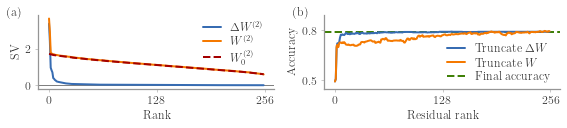

In [53]:
# Join figures
n_row = 1
n_col = 2

fig = plt.figure(figsize=(fig_width, 0.24 * fig_width), facecolor='w')
axes = fig.subplots(n_row, n_col)
ax_sv = axes[0]
ax_acc = axes[1]

#########################################################################
### Singular values
#########################################################################
# Choose recurrent weights, second layer
layer = 1
key = 'rnn.weight_hh_l%d' % layer
ax = ax_sv
w_str = "%s^{(%d)}" % ("W", 2)

# Initial, final, changes
for j in range(n_all):
    in_rec, layer_str = key.split('.')[1].split('_')[1:]
    # Plot
    i_j = [2, 1, 0][j]
    c = colors[[0, 1, 3][j]]
    ls = ['--', '-', '-'][i_j]
    s = s_all[i_j][key]
    lbl = ["$%s_0$"%w_str, "$%s$"%w_str, "$\Delta %s$"%w_str][i_j]
    ax.plot(s, ls=ls, c=c, label=lbl, lw=lw)

# Polish
ax.axhline(0, c=c_leg, zorder=-1)
ax.set_xticks([0, nhid // 2, nhid])
ax.set_xlabel("Rank")
ax.set_ylabel("SV")

leg = ax.legend(loc=1, ncol=1, labelspacing=0.1, handlelength=1.5, frameon=False)#False)
# Move legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.0
bb.x0 += xOffset
bb.x1 += xOffset
yOffset = 0.07
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
            
    
#########################################################################
### Accuracy
#########################################################################
# Truncation accuracy
train_loss, valid_loss, train_acc, valid_acc = loss_acc.T
ax = ax_acc
for j in range(2):
    c = colors[[0, 1]][j]
    lbl = [r'Truncate $\Delta W$', 'Truncate $W$'][j]
    trunc_loss, trunc_acc = trunc_loss_acc[j].T
    ax.plot(trunc_ranks, trunc_acc, c=c, label=lbl, lw=lw)
ax.set_xlabel("Residual rank")
ax.set_xticks([0, nhid // 2, nhid])
# ax.set_yticklabels([])

# Polish accuracy
ylim_acc = 0.45, 0.89
ax.set_ylim(*ylim_acc)
ax.set_yticks([0.5, 0.8])
# Final accuracy
ax.axhline(valid_acc[-1], ls='--', c=colors[2], label='Final accuracy', zorder=-1, lw=lw)
ax.set_ylabel('Accuracy')

leg = ax.legend(loc=4, 
          ncol=1,
          labelspacing=0.1, handlelength=1.5, frameon=False)#False)
# Move legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.00
bb.x0 += xOffset
bb.x1 += xOffset
yOffset = -0.07
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    
# Label plots
ax_idxs = [0, 1]
for i, ax_idx in enumerate(ax_idxs):
    xpos = -0.1
    ax = fig.axes[ax_idx]
    ax.text(xpos, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
style.fixticks(fig)
fig_name = data_file_name + "_low_rank"
fig_name = "".join(fig_name.split('.'))
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
plt.show(fig)
plt.close(fig)

Save figure to ../../tex/neurips_2020/submission_2/figures\sst_lstm_nlayers_2_nhid_256_emb_pretrained_fix_dim_100_dropout_05_weight_decay_0000_seed_6080_low_rank_details.pdf


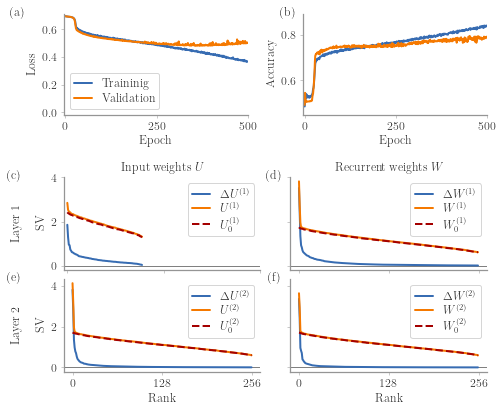

In [54]:
# Join figures
n_row = 1 + nlayers
n_col = 2

# Subplot positions
dy = 0.08
y1 = 0.62
bottoms = [y1 + dy, dy/2]
tops = [1 - dy/2, y1 - dy]

# fig = plt.figure(figsize=(fig_width, 1.4 * fig_height))
fig = plt.figure(figsize=(6, 1.8 * n_row), facecolor='w')
gs0 = GridSpec(1, n_col)
gs0.update(left=0.01, right=0.99, bottom=bottoms[0], top=tops[0], wspace=0.3, hspace=0.15)
axes_acc = [plt.subplot(gs0[0, k]) for k in range(n_col)]

gs0 = GridSpec(nlayers, n_col)
gs0.update(left=0.01, right=0.99, bottom=bottoms[1], top=tops[1], wspace=0.15, hspace=0.1)
axes_sv = np.array([[plt.subplot(gs0[j, k]) for k in range(n_col)] for j in range(nlayers)])

#########################################################################
### Accuracy
#########################################################################
# Loss over training
n_epochs = len(train_loss)
epochs = np.arange(n_epochs)
ax = axes_acc[0]
ax.plot(epochs, train_loss, c=colors[0], lw=lw, label='Traininig')
ax.plot(epochs, valid_loss, c=colors[1], lw=lw, label='Validation')
ax.set_xlabel('Epoch')
ax.set_xlim(-5, 105)
ax.set_xticks([0, n_epochs // 2, n_epochs])
ax.set_ylabel('Loss')
ax.set_ylim(-0.02, None)
ax.legend(loc=3, ncol=1, labelspacing=0.1, handlelength=1.5, frameon=True)#False)

# Accuracy over training
n_epochs = len(train_loss)
epochs = np.arange(n_epochs)
ax = axes_acc[1]
ax.plot(epochs, train_acc, c=colors[0], lw=lw, label='Traininig')
ax.plot(epochs, valid_acc, c=colors[1], lw=lw, label='Validation')
# ax.plot(epochs, train_acc, c=colors[0], label='train')
# ax.plot(epochs, valid_acc, c=colors[1], label='valid')
ax.set_xlabel('Epoch')
ax.set_xlim(-5, 105)
ax.set_xticks([0, n_epochs // 2, n_epochs])
ax.set_ylabel('Accuracy')
ylim_acc = 0.45, 0.89
ax.set_ylim(*ylim_acc)
    
#########################################################################
### Singular values
#########################################################################
# Initial, final, changes
for j in range(n_all):
    i_j = [2, 1, 0][j]
    c = colors[[0, 1, 3][j]]
    ls = ['--', '-', '-'][i_j]
    for i, key in enumerate(keys_w):
        
        if 'rnn' in key:
            in_rec, layer_str = key.split('.')[1].split('_')[1:]
            layer = int(layer_str[1:])
            if in_rec == 'ih':
                i_ax = 0
            else:
                i_ax = 1
            ax = axes_sv[layer, i_ax]

            # Plot
            s = s_all[i_j][key]
            w_str = "%s^{(%d)}" % (["U", "W"][i_ax], layer+1)
            lbl = ["$%s_0$"%w_str, "$%s$"%w_str, "$\Delta %s$"%w_str][i_j]
#             lbl = ["$W_0$", "W", "$\Delta W$"][i_j]
            ax.plot(s, ls=ls, c=c, label=lbl, lw=lw)
        
for j in range(nlayers):
    for i in range(n_col):
        ax = axes_sv[j, i]
        ax.axhline(0, c=c_leg, zorder=-1)
        
#         if j == 0:
        # Legend
        ax.legend(loc=1, ncol=1, labelspacing=0.1, handlelength=1.5, frameon=True)#False)
            
        ax.set_xticks([0, nhid // 2, nhid])
        if j < nlayers-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Rank")
            
        if i == 0:
#             ax.set_ylabel("Layer %d\n\nSingular values" % (j+1))
            ax.set_ylabel("Layer %d\n\nSV" % (j+1))
#         w_str = ["U", "W"][i]
#         ax.set_ylabel(r"Layer %d, $SV(%s)$" % (j, w_str))
        
for j in range(nlayers):
    ymin = min([ax.get_ylim()[0] for ax in axes_sv[j]])
    ymax = max([ax.get_ylim()[1] for ax in axes_sv[j]])
    for i, ax in enumerate(axes_sv[j]):
        ax.set_ylim(ymin, ymax)
        if i > 0:
            ax.set_yticklabels([])
for i, ax in enumerate(axes_sv[0]):
    title = ["Input weights $U$", "Recurrent weights $W$"][i]
    ax.set_title(title, fontsize=fs)
    
# Label plots
ax_idxs = [0, 1, 2, 3, 4, 5]
for i, ax_idx in enumerate(ax_idxs):
    if i % 2 == 0:
        xpos = -0.25
    else:
        xpos = -0.08
    ax = fig.axes[ax_idx]
    ax.text(xpos, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

style.fixticks(fig)
fig_name = data_file_name + "_low_rank_details"
fig_name = "".join(fig_name.split('.'))
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
plt.show(fig)
plt.close(fig)

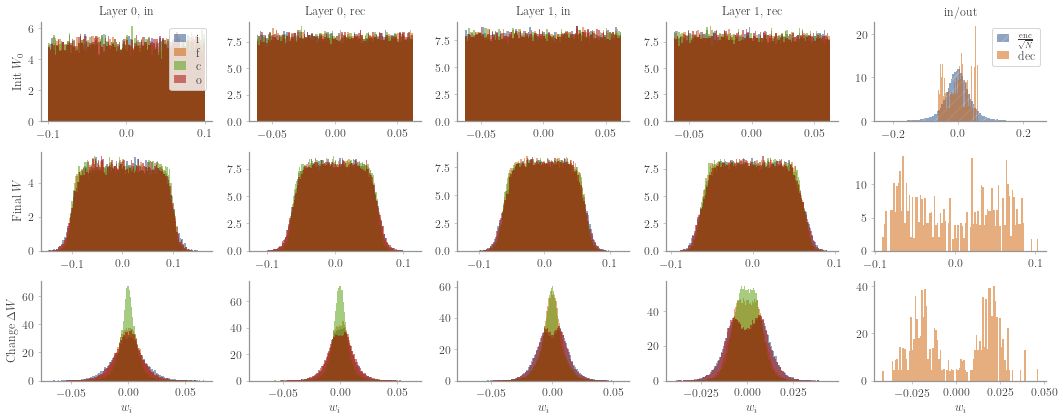

In [269]:
### Plot distribution of weights


n_col = 2 * nlayers + 1
n_row = n_all
fig = plt.figure(figsize=(3 * n_col, 6), facecolor='w')
axes = fig.subplots(n_row, n_col)
alpha = 0.5
n_bins = 100
# Initial, final, changes
for j, state_dict in enumerate(state_dicts):
    for i, key in enumerate(keys_w):
        if 'rnn' in key:
            in_rec, layer_str = key.split('.')[1].split('_')[1:]
            layer = int(layer_str[1:])
            if in_rec == 'ih':
                i_ax = 2 * layer
            else:
                i_ax = 2 * layer + 1
        else:
            i_ax = nlayers * 2

        # Plot
        ax = axes[j, i_ax]
        if 'rnn' in key:
            # The LSTM weights come in blocks of 4 * N x N. Separate these blocks first!
            w_rnn = state_dict[key]
            for k, key_rnn in enumerate(keys_rnn):
                w = w_rnn[k * nhid : (k+1) * nhid]
                c = colors[k]
                ax.hist(w.flatten(), bins=n_bins, density=True, color=c, linewidth=0, alpha=alpha, label=key_rnn)
        else:
            c = colors[0 if i == 0 else 1]
            lbl = key.split('.')[0]
            w = state_dict[key]
            w_sample = np.random.choice(w.flatten(), nhid**2)
            # Encoder and decoder weights have different scaling (O(1), O(1/N)). Rescale for plotting!
            if lbl == 'encoder' and (j == 0 or train_emb):
                if j < 2:
                    fac = 1 / np.sqrt(nhid)
                    lbl_fac = r"$\frac{\mathrm{enc}}{\sqrt{N}}$"
                    hatch = '//'
                else:
                    fac = 1
                    lbl_fac = lbl
                    hatch = None
                ax.hist(w_sample * fac, bins=n_bins, density=True, 
                        color=c, hatch=hatch, edgecolor='0.8', linewidth=0, alpha=alpha, label=lbl_fac)
            elif lbl == 'decoder':
                ax.hist(w_sample, bins=n_bins, density=True, 
                        color=c, edgecolor='0.8', linewidth=0, alpha=alpha, label='dec')
            
# Titles
titles = []
for layer in range(nlayers):
    titles.append('Layer %d, in' %layer)
    titles.append('Layer %d, rec' %layer)
titles.append('in/out')
for i, title in enumerate(titles):
    ax = axes[0, i]
    ax.set_title(title)
# Legend
ax = axes[0, 0]
ax.legend(loc=1, ncol=1, labelspacing=0.05, handlelength=1.)
ax = axes[0, -1]
ax.legend(loc=1, ncol=1, labelspacing=0.05, handlelength=1.)
# x and y labels
for j in range(n_row):
    for i in range(n_col):
        ax = axes[j, i]
        if j == n_row-1:
            ax.set_xlabel("$w_i$")
#         else:
#             ax.set_xticklabels([])
y_labels = ["Init $W_0$", "Final $W$", "Change $\Delta W$"]
for j, y_label in enumerate(y_labels):
    ax = axes[j, 0]
    ax.set_ylabel(y_label)

fig.tight_layout()
style.fixticks(fig)
fig_name = data_file_name + "_w_stats"
fig_name = "".join(fig_name.split('.'))
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
plt.show(fig)
plt.close(fig)